# Principal Component Analysis... without np.linalg.eig()

PCA is a form of unsupervised data compression. It aims to find the directions of maximum statistical variance in a high dimensional space and use these directions to project the data to a lower dimensional space. The axis of the  subspace can be thought of as the directions of maximum variance in a dataset as achieved under the constraint that these new axis be orthogonal to each other.

Given a dataset of *d* feature dimensions, we can project the dataset onto a subspace of *k* feature dimensions using a projection martrix of *d* x *k* dimensions. To build the projection matrix we must first create a *d* x *d* covariance matrix and then find the top eigenvalues and vectors for the covariance matrix. The projection matrix is a concatencation of the top *k* eigenvectors with the greatest respective eigenvalues. 

In this notebook I will demonstrate how to find the eigenvalues and eigenvectors without use of numpy's eig() function, instead using an eigenvalue algorithm known as **power iteration**.



In [29]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

### Import and Preprocess Data

The dataset here is on the charactistics of the kernels from three different varieties of <s>linux</s> wheat.
<p>
<tiny>[Dataset description and download page.](https://archive.ics.uci.edu/ml/datasets/seeds)</tiny>

In [30]:
#import from tsv file
df = pd.read_csv('./seeds_dataset.tsv', header=None, sep='\t')

#add column labels
df.columns = ['seed-area','seed-perimeter','seed-compactness',
              'kernel-length','kernel-width','asymmetry-coefficient',
              'kernel-groove-length','class']

#replace integer classes with the name of the wheat varietal
df['class'] = df['class'].replace(to_replace=[1,2,3],
                                  value=["Kama","Rosa","Canadian"])


### Standardize the Dataset

In [31]:
X = df.ix[:,0:7].values

# mean = 0, variance = 1
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

y = df.ix[:,7].values

### Construct the Covariance Matrix

In [32]:
mean_vector       = np.mean(X, axis=0)
covariance_matrix = (X - mean_vector).T.dot((X - mean_vector)) / (X.shape[0]-1)
print(covariance_matrix)

[[ 1.00478469  0.99909854  0.61119889  0.9545308   0.97541544 -0.23067077
   0.86782525]
 [ 0.99909854  1.00478469  0.53177587  0.97707507  0.94935008 -0.21838028
   0.89504603]
 [ 0.61119889  0.53177587  1.00478469  0.36967551  0.7652787  -0.33305686
   0.22791011]
 [ 0.9545308   0.97707507  0.36967551  1.00478469  0.86453176 -0.1723833
   0.93726927]
 [ 0.97541544  0.94935008  0.7652787   0.86453176  1.00478469 -0.25927117
   0.75271583]
 [-0.23067077 -0.21838028 -0.33305686 -0.1723833  -0.25927117  1.00478469
  -0.01113203]
 [ 0.86782525  0.89504603  0.22791011  0.93726927  0.75271583 -0.01113203
   1.00478469]]


### Decompose the Covariance Matrix into its Eigenvectors and Eigenvalues 
## WITHOUT USING np.linalg.eig()

In [33]:
def power_iteration(matrix):
    # construct a vector of noise that will become the eigenvector after n iterations
    vec = np.random.rand(matrix.shape[0])
    
    # set number of iterations for the vector to converge on the eigenvector values
    iterations = 10000
    
    for _ in range(iterations):
        # calculate the matrix by vector product
        product = np.dot(matrix, vec)
        
        # calculate the norm
        vec_norm = np.linalg.norm(product)
        
        # renormalize the vector
        vec = product / vec_norm
    
    eigenvector = np.array([vec]).T
    eigenvalue  = vec_norm
    
    return eigenvector, eigenvalue

def deflate_matrix(matrix, eigenvector, eigenvalue):
    
    u = np.divide(eigenvector, np.linalg.norm(eigenvector))
    deflated_matrix = matrix - (eigenvalue * u.dot(u.T))
    
    return deflated_matrix

### What is going on here??

Given: $Ax = \lambda x$ <p>
Where: $A$ is our matrix being input into the power_iteration fnx and $\lambda$ is the eigenvalue we are searching for.

We can take advantage of: <p>
$x_{i+1} = \frac{Ax_{i}}{||Ax_{i}||}$ <p>
and <p>
$\lambda_{i+1} = ||Ax_{i}||$ <p>
<p>




On every iteration we move from $i$ to $i + 1$ in the system of equations above and we
converge on the largest eigenvalue $\lambda$ which is calculated in the code by the np.linalg.norm() function. The eigenvector is approxmiated when we normalize the vector at the end of the for loop.

For an *n* by *n* matrix there are *n* eigenvectors and eigenvalues that we can find. To find the next largest eigenpair, we run the deflate matrix function. This shrinks the matrix in its *n* dimensional space by subtracting out the largest eigenvalue from this space allowing us to use power iteration to converge on the next largest eigenpair. We then feed this deflated matrix into the power iteration function to find the next eigenpair, repeating until we have *n* eigenpairs.

For more info on power iteration and matrix deflation please see my references section.

In [34]:
def decompose_to_eigenpairs(matrix):
    eigenvals = []
    eigenvecs = []
    for _ in range(matrix.shape[0]):
        # perform power method on covariance matrix to retrieve eigenpair
        vec, val = power_iteration(matrix)
        # deflate matrix so we can get the next smallest eigenvalue on the next iteration
        matrix = deflate_matrix(matrix, vec, val)
        
        # save eigenpair from this iteration
        eigenvals.append(val)
        eigenvecs.append(vec[:,0])
        
    eigenpairs = [(np.abs(eigenvals[i]), eigenvecs[i]) for i in range(matrix.shape[0])]
    
    return eigenpairs

In [35]:
eigenpairs = decompose_to_eigenpairs(covariance_matrix)

print('Eigenvalues in descending order:\n')
for i in eigenpairs:
    print(i[0])

Eigenvalues in descending order:

5.05527391892
1.20330286059
0.681247474172
0.0686915797528
0.0188031478018
0.00535755786167
0.0008162838655


In the cell below, I will calculate the eigenpairs using np.linalg.eig() to prove that I am getting the proper eigenvalues for this dataset using the method above. I will not be using any values generated by np.linalg.eig() to create the projection matrix.

In [36]:
eigvals, eigvecs = np.linalg.eig(covariance_matrix)
eigpairs_via_numpy = [(np.abs(eigvals[i]), eigvecs[:,i]) for i in range(len(eigvals))]
eigpairs_via_numpy.sort(key=lambda x: x[0], reverse=True)

print('Eigenvalues, according to np.linalg.eig(), in descending order:')
for i in eigpairs_via_numpy:
    print(i[0])


Eigenvalues, according to np.linalg.eig(), in descending order:
5.05527391892
1.20330286059
0.681247474172
0.0686915797528
0.0188031478018
0.00535755786167
0.0008162838655


As you can see the resulting eigenvalues are identical! The power method works.

The eigenvectors values are the same as well:

In [37]:
for i in range(len(eigenpairs)):
    print("Eigenvector %s:" % str(i+1))
    print(eigenpairs[i][1])
    print(eigpairs_via_numpy[i][1])

Eigenvector 1:
[ 0.44447352  0.44157147  0.27701737  0.42356333  0.43281866 -0.11869248
  0.38716084]
[ 0.44447352  0.44157147  0.27701737  0.42356333  0.43281866 -0.11869248
  0.38716084]
Eigenvector 2:
[ 0.02656355  0.08400282 -0.52915125  0.20597518 -0.11668963  0.71688203
  0.37719327]
[ 0.02656355  0.08400282 -0.52915125  0.20597518 -0.11668963  0.71688203
  0.37719327]
Eigenvector 3:
[ 0.02587094 -0.05983912  0.62969178 -0.21187966  0.21648338  0.67950584
 -0.2138972 ]
[-0.02587094  0.05983912 -0.62969178  0.21187966 -0.21648338 -0.67950584
  0.2138972 ]
Eigenvector 4:
[ 0.19363997  0.29545659 -0.3328164   0.26340659  0.19963039  0.09246481
 -0.80414995]
[ 0.19363997  0.29545659 -0.3328164   0.26340659  0.19963039  0.09246481
 -0.80414995]
Eigenvector 5:
[-0.20441167 -0.17427591  0.33265481  0.76609839 -0.46536555  0.03625822
 -0.11134657]
[ 0.20441167  0.17427591 -0.33265481 -0.76609839  0.46536555 -0.03625822
  0.11134657]
Eigenvector 6:
[-0.42643686 -0.47623853 -0.14162884  0.

### Select Number of Eigenpairs to Create Subspace

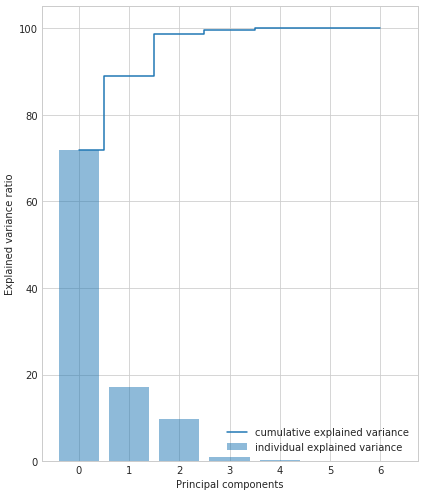

In [38]:
eig_vals = [val[0] for val in eigenpairs]
tot = sum(eig_vals)

var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)


with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 7))

    plt.bar(range(7), var_exp, alpha=0.5, align='center',
            label='individual explained variance')
    plt.step(range(7), cum_var_exp, where='mid',
             label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

Here we can see that the first two pricinpal components explain nearly 90% of the variance among the data. We should be able to visualize the three different classes in our data well in two dimensions. 

### Construct a Projection Matrix from Top Eigenvectors 

In [39]:
matrix_w = np.hstack((eigenpairs[0][1].reshape(7,1),eigenpairs[1][1].reshape(7,1)))

print("Projection Matrix:\n", matrix_w)

Projection Matrix:
 [[ 0.44447352  0.02656355]
 [ 0.44157147  0.08400282]
 [ 0.27701737 -0.52915125]
 [ 0.42356333  0.20597518]
 [ 0.43281866 -0.11668963]
 [-0.11869248  0.71688203]
 [ 0.38716084  0.37719327]]


### Transform Original Dataset into Compressed Subspace

In [40]:
Y = X.dot(matrix_w)

### Plot Subspace

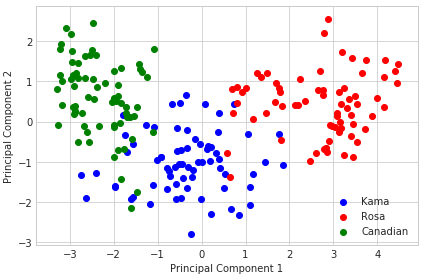

In [41]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 4))
    for lab, col in zip(('Kama', 'Rosa', 'Canadian'), 
                        ('blue', 'red', 'green')):
        plt.scatter(Y[y==lab, 0],
                    Y[y==lab, 1],
                    label=lab,
                    c=col)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower right')
    plt.tight_layout()

### References

* https://www.youtube.com/watch?v=Yhs0Fcpv6y4&t=322s
* https://en.wikipedia.org/wiki/Power_iteration
* http://distance-ed.math.tamu.edu/Math640/chapter6/node4.html